In [102]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [1]:
# Uploading downloaded CSV files to the Database in MySQL.

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder path containing the CSV files
folder_path = 'C:/Users/admin/Desktop/ecommorce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    conn.commit()
conn.close()

NameError: name 'mysql' is not defined

In [64]:
db = mysql.connector.connect(
    host= 'localhost',
    username= 'root',
    password= 'Vijay@986744',
    database= 'ecommerce'
    )

cur = db.cursor()

In [26]:
# List all unique cities where customers are located.

query = '''select distinct customer_city from customers'''
cur.execute(query)
data = cur.fetchall()

columns_name = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=columns_name)

print(df.head(10))

print(df.tail(10))

           customer_city
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas
5         jaragua do sul
6                timoteo
7               curitiba
8         belo horizonte
9          montes claros
            customer_city
4109             balbinos
4110         serra bonita
4111         venda branca
4112          sanga puita
4113              queiroz
4114               siriji
4115  natividade da serra
4116         monte bonito
4117           sao rafael
4118    eugenio de castro


In [30]:
# Count the number of orders placed in 2017

query = '''select * from orders'''

cur.execute(query)

order_data = cur.fetchall()

columns_name = [desc[0] for desc in cur.description]

df = pd.DataFrame(order_data, columns=columns_name)

df['purchased_year'] = pd.to_datetime(df['order_purchase_timestamp']).dt.year

orders_2017 = df[df['purchased_year'] == 2017]

num_of_orders_2017 = orders_2017['order_id'].count()

print(f"Number of orders placed in 2017 : {num_of_orders_2017}")


Number of orders placed in 2017 : 90202


In [31]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''
cur.execute(query)
data = cur.fetchall()
print(f"Total orders placed in 2017 are: {data[0][0]}")

Total orders placed in 2017 are: 90202


In [36]:
# Find the total sales per category

query = '''
            select p.product_category as category, round(sum(pt.payment_value), 2) as sales
            from products p 
            join order_items o on o.product_id = p.product_id
            join payments pt on pt.order_id = o.order_id
            group by category
        '''

cur.execute(query)

category_sales = cur.fetchall()

columns_name = [desc[0] for desc in cur.description]

df = pd.DataFrame(category_sales, columns=columns_name)


print(df.head())
print(df.tail())

               category       sales
0             perfumery   506738.66
1  Furniture Decoration  1430176.39
2             telephony   486882.05
3        bed table bath  1712553.67
4            automotive   852294.33
                       category    sales
69               cds music dvds  1199.43
70                   La Cuisine  2913.53
71  Fashion Children's Clothing   785.67
72                     PC Gamer  2174.43
73       insurance and services   324.51


In [44]:
# Calculate the percentage of orders that were paid in installments.


query = '''
            select sum(case when payment_installments >=1 then 1 else 0 end)/count(*)*100 as installment_orders_percentage
            from payments
        '''

cur.execute(query)

column_names = [desc[0] for desc in cur.description]

installment_percentage = cur.fetchall()

df = pd.DataFrame(installment_percentage, columns=column_names)
df

,installment_orders_percentage
0,99.9981


  customer_state  no_of_customers
0             SP            83492
4             RJ            25704
2             MG            23270
5             RS            10932
3             PR            10090
   customer_state  no_of_customers
20             RO              506
17             AM              296
24             AC              162
18             AP              136
26             RR               92


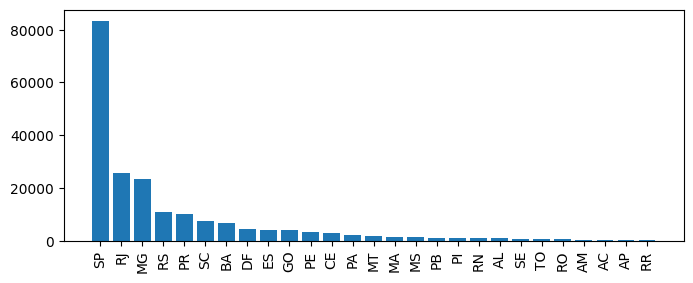

In [52]:
# Count the number of customers from each state.

query = '''
            select customer_state, count(customer_unique_id) as no_of_customers
            from customers
            group by customer_state
        '''

cur.execute(query)

customers_per_state = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(customers_per_state, columns=column_names)
df = df.sort_values(by = 'no_of_customers', ascending = False)

print(df.head())
print(df.tail())

plt.figure(figsize = (8,3))
plt.bar(df['customer_state'], df['no_of_customers'])
plt.xticks(rotation = 90)
plt.show()

In [61]:
# Calculate the number of orders per month in 2018.


query = '''
            select month(order_purchase_timestamp) as months_of_2018, count(order_id) as no_of_orders
            from orders
            where year(order_purchase_timestamp) = 2018
            group by months_of_2018
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)
df = df.sort_values(by = 'months_of_2018', ascending=True)
df

,months_of_2018,no_of_orders
5,1,14538
2,2,13456
4,3,14422
7,4,13878
6,5,13746
3,6,12334
0,7,12584
1,8,13024
8,9,32
9,10,8


In [74]:
# Find the average number of products per order, grouped by customer city.


query = '''
            with products_per_order as
            (select order_id, count(product_id) as no_of_products
            from order_items
            group by order_id)

            select c.customer_city, round(avg(po.no_of_products), 2) as avg_product_num
            from products_per_order po
            join orders o on o.order_id = po.order_id
            join customers c on c.customer_id = o.customer_id
            group by c.customer_city
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

     customer_city avg_product_num
0        sao paulo          1.1562
1        urussanga          1.0000
2           macapa          1.1481
3         salvador          1.1405
4  itaquaquecetuba          1.0526
               customer_city avg_product_num
4105      tabuleiro do norte          1.0000
4106                pacotuba          1.0000
4107    presidente juscelino          1.0000
4108  desterro de entre rios          1.0000
4109                 maquine          1.0000


In [94]:
# Calculate the percentage of total revenue contributed by each product category.

query = '''
            with user_payments as
            (
            select order_id, sum(payment_value) as payment_value
            from payments
            group by order_id
            ),

            fetched_category as
            (
            select p.product_category, round(sum(u.payment_value), 2) as category_revenue
            from user_payments u
            join order_items oi on oi.order_id = u.order_id
            join products p on oi.product_id = p.product_id
            group by p.product_category
            )

            select product_category, category_revenue, round((category_revenue/sum(category_revenue) over())*100, 2) as category_revenue_percent
            from fetched_category
        '''

cur.execute(query)

data = cur.fetchall()

column_names = column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

df = df.sort_values(by='category_revenue_percent', ascending=False)

print(df.head(5))
print(df.tail(5))

        product_category  category_revenue  category_revenue_percent
3         bed table bath        1712553.67                      8.43
11         HEALTH BEAUTY        1657373.12                      8.16
5   computer accessories        1585330.45                      7.81
1   Furniture Decoration        1430176.39                      7.04
15       Watches present        1429216.68                      7.04
               product_category  category_revenue  category_revenue_percent
69               cds music dvds           1199.43                      0.01
70                   La Cuisine           2913.53                      0.01
72                     PC Gamer           2174.43                      0.01
71  Fashion Children's Clothing            785.67                      0.00
73       insurance and services            324.51                      0.00


In [104]:
# Identify the correlation between product price and the number of times a product has been purchased.

query = '''
            select p.product_category, count(oi.product_id) as products_num,
            round(avg(oi.price), 2) as avg_price
            from products p
            join order_items oi on p.product_id = oi.product_id
            group by p.product_category
        '''

cur.execute(query)

data = cur.fetchall()

column_names = column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

#print(df.head())
#print(df.tail())

arr1 = df['products_num']
arr2 = df['avg_price']
a = np.corrcoef([arr1, arr2])
print("The correlation between price and number of times product purchased is : ", a[0][1])

The correlation between price and number of times product purchased is :  -0.10631514167157562


In [108]:
# Calculate the total revenue generated by each seller, and rank them by revenue.

query = '''
            with cte as 
            (
            select oi.seller_id, round(sum(pt.payment_value), 2) as revenue
            from order_items oi
            join payments pt on oi.order_id = pt.order_id
            group by oi.seller_id
            )

            select *, dense_rank() over(order by revenue desc) as rnk
            from cte
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

                          seller_id    revenue  rnk
0  7c67e1448b00f6e969d365cea6b010ab  507166.91    1
1  1025f0e2d44d7041d6cf58b6550e0bfa  308222.04    2
2  4a3ca9315b744ce9f8e9374361493884  301245.27    3
3  1f50f920176fa81dab994f9023523100  290253.42    4
4  53243585a1d6dc2643021fd1853d8905  284903.08    5
                             seller_id  revenue   rnk
3090  ad14615bdd492b01b0d97922e87cb87f    19.21  3076
3091  702835e4b785b67a084280efca355756    18.56  3077
3092  4965a7002cca77301c82d3f91b82e1a9    16.36  3078
3093  77128dec4bec4878c37ab7d6169d6f26    15.22  3079
3094  cf6f6bc4df3999b9c6440f124fb2f687    12.22  3080


In [110]:
# Calculate the moving average of order values for each customer over their order history.

query = '''
            with mvg_avg_data as
            (
            select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
            from payments p
            join orders o on p.order_id = o.order_id
            )
            
            select customer_id, order_purchase_timestamp, payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from mvg_avg_data
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

                        customer_id order_purchase_timestamp  payment  \
0  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
2  000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
3  000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
4  0001fd6190edaaf884bcaf3d49edf079      2017-02-28 11:06:43   195.42   

      mov_avg  
0  114.739998  
1  114.739998  
2   67.410004  
3   67.410004  
4  195.419998  
                             customer_id order_purchase_timestamp  payment  \
207767  ffff42319e9b2d713724ae527742af25      2018-06-13 16:57:05   214.13   
207768  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
207769  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
207770  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
207771  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37 

In [111]:
# Calculate the cumulative sales per month for each year.

query = '''
            with cumulative_sales as
            (
            select year(o.order_purchase_timestamp) as years, month(o.order_purchase_timestamp) as months,
            round(sum(pt.payment_value), 2) as payment
            from orders o
            join payments pt on o.order_id = pt.order_id
            group by years, months
            order by years, months
            )
            
            select years, months, payment, sum(payment) over(order by years, months) as cumulative_sales
            from cumulative_sales
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

   years  months    payment  cumulative_sales
0   2016       9     504.48            504.48
1   2016      10  118180.96         118685.44
2   2016      12      39.24         118724.68
3   2017       1  276976.08         395700.76
4   2017       2  583816.02         979516.78
    years  months     payment  cumulative_sales
20   2018       6  2047761.00       27829753.68
21   2018       7  2133081.50       29962835.18
22   2018       8  2044850.64       32007685.82
23   2018       9     8879.08       32016564.90
24   2018      10     1179.34       32017744.24


In [115]:
# Calculate the year-over-year growth rate of total sales.

query = '''
            with growth_rate as
            (
            select year(o.order_purchase_timestamp) as years,
            round(sum(pt.payment_value), 2) as payment
            from orders o
            join payments pt on o.order_id = pt.order_id
            group by years
            order by years
            )
            
            select years, round((payment - lag(payment, 1) over(order by years))/
            lag(payment, 1) over(order by years)*100, 2) as YoY_growth
            from growth_rate
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

   years  YoY_growth
0   2016         NaN
1   2017     12112.7
2   2018        20.0
   years  YoY_growth
0   2016         NaN
1   2017     12112.7
2   2018        20.0


In [117]:
# Identify the top 3 customers who spent the most money in each year.

query = '''
            with spent_more_money as
            (
            select year(o.order_purchase_timestamp) as years, o.customer_id,
            round(sum(pt.payment_value), 2) as payment, dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(pt.payment_value) desc) as d_rank 
            from orders o
            join payments pt on o.order_id = pt.order_id
            group by years, o.customer_id
            )
            
            select years, customer_id, payment, d_rank
            from spent_more_money
            where d_rank <=3
        '''

cur.execute(query)

data = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(data, columns=column_names)

print(df.head(5))
print(df.tail(5))

   years                       customer_id   payment  d_rank
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   2847.10       1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   2801.48       2
2   2016  4a06381959b6670756de02e07b83815f   2455.56       3
3   2017  1617b1357756262bfa56ab541c47bc16  27328.16       1
4   2017  c6e2731c5b391845f6800c97401a43a9  13858.62       2
   years                       customer_id   payment  d_rank
4   2017  c6e2731c5b391845f6800c97401a43a9  13858.62       2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6  13453.32       3
6   2018  ec5b2ba62e574342386871631fafd3fc  14549.76       1
7   2018  f48d464a0baaea338cb25f816991ab1f  13844.42       2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358   9618.88       3
